## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)



## Second, Calculate distortion coefficients, and test undistortion on an image...

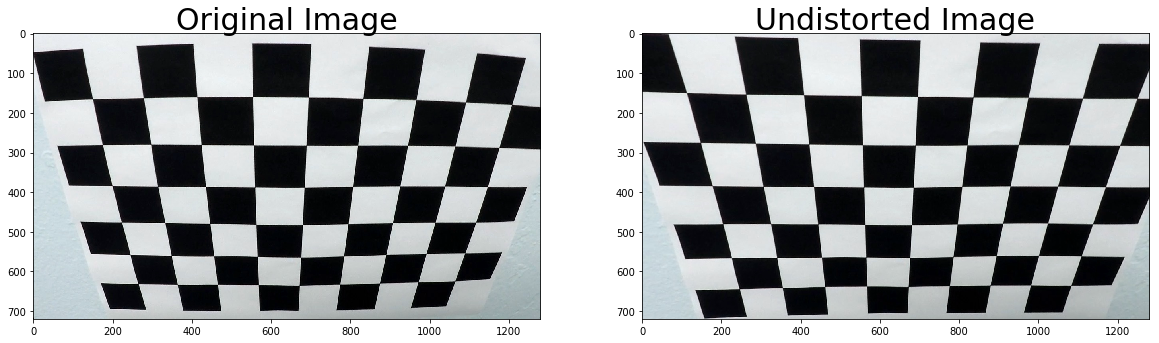

In [2]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration2.jpg')
image_shape = img.shape
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
undist_warped = cv2.undistort(img, mtx, dist_coeffs, None, mtx)

cv2.imwrite('examples/test_undist.jpg',undist_warped)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_warped)
ax2.set_title('Undistorted Image', fontsize=30)

## Third, Color and Gradient thresholding

### Color thresholding (S channel in HLS color space)
  This does a fairly robust job of picking up the lines under very different color and contrast conditions.
  It is especially good in picking up the yellow lanes
  
  
### Graident thresholding 
  This uses sobel operation to detect the edges after converting the color image to the gray image first.
  Sobel X gradient operations is good at picking up lines close to the vertical line.

In [189]:
# hls_select: apply S channel threshold in HLS color space
def apply_color_thresh(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    hls_s = hls[:,:,2]
    bin_mask = np.zeros_like(hls_s)
    bin_mask[(hls_s > thresh[0]) & (hls_s <= thresh[1])] = 1
       
    # 3) Return a binary image of threshold result
    return bin_mask
    

def apply_gradient_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    sobel_gradient = cv2.Sobel(gray, cv2.CV_64F, (orient=='x'), (orient!='x'))
    # 2) Take the absolute value of the derivative or gradient
    abs_sobel = np.abs(sobel_gradient)
    # 3) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(abs_sobel*255 / np.max(abs_sobel))
    # 4) Create a mask of 1's where the scaled gradient magnitude 
    bin_mask = np.zeros_like(scaled_sobel)
    bin_mask[(scaled_sobel >= thresh_min) & (scaled_sobel < thresh_max )] = 1
    
    # 6) Return this mask as your binary_output image
    return bin_mask


def apply_dir_thresh(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobel_y,abs_sobel_x)
    direction = np.absolute(direction)
    # 5) Create a binary mask where direction thresholds are met
    bin_mask = np.zeros_like(direction)
    bin_mask[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return bin_mask


def apply_lane_threshold(image):   
    undist_img = cv2.undistort(image, mtx, dist_coeffs, None, mtx)
    
    # apply S (in HLS color space) channel threshold min, max
    color_thresh = (170, 255)    
    color_bin = apply_color_thresh(undist_img, color_thresh)
    
    # convert the color image to grayscale image
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    # Sobel gradient operation threshold min, max 
    gradient_thresh = (20, 100) 
    # Sobel operation direction ('x', 'y')
    sobel_orient = 'x'
    # apply sobel gradient thresholding to detect the edges
    gradient_bin = apply_gradient_thresh(gray, sobel_orient, gradient_thresh[0], gradient_thresh[1])
    # apply gradient direction threshold so that only edges closer to vertical are detected.
    dir_bin = apply_dir_thresh(gray, thresh=(np.pi/6, np.pi/2))

    # combined condition of sober gradient and direction threshold
    combined_condition = ((gradient_bin == 1) & (dir_bin == 1))
    
    # color and gradient thresholds combined
    thresholded_bin = np.zeros_like(color_bin)
    thresholded_bin[(color_bin == 1) | (combined_condition == 1)] = 1

    # additional masking out 
    #mask = np.zeros_like(color_bin)
    #mask[300:720,170:1100,] = 1
    #thresholded_bin = thresholded_bin & mask
    
    return thresholded_bin


### Color/Gradient Thresholding Verification (1) 

921600


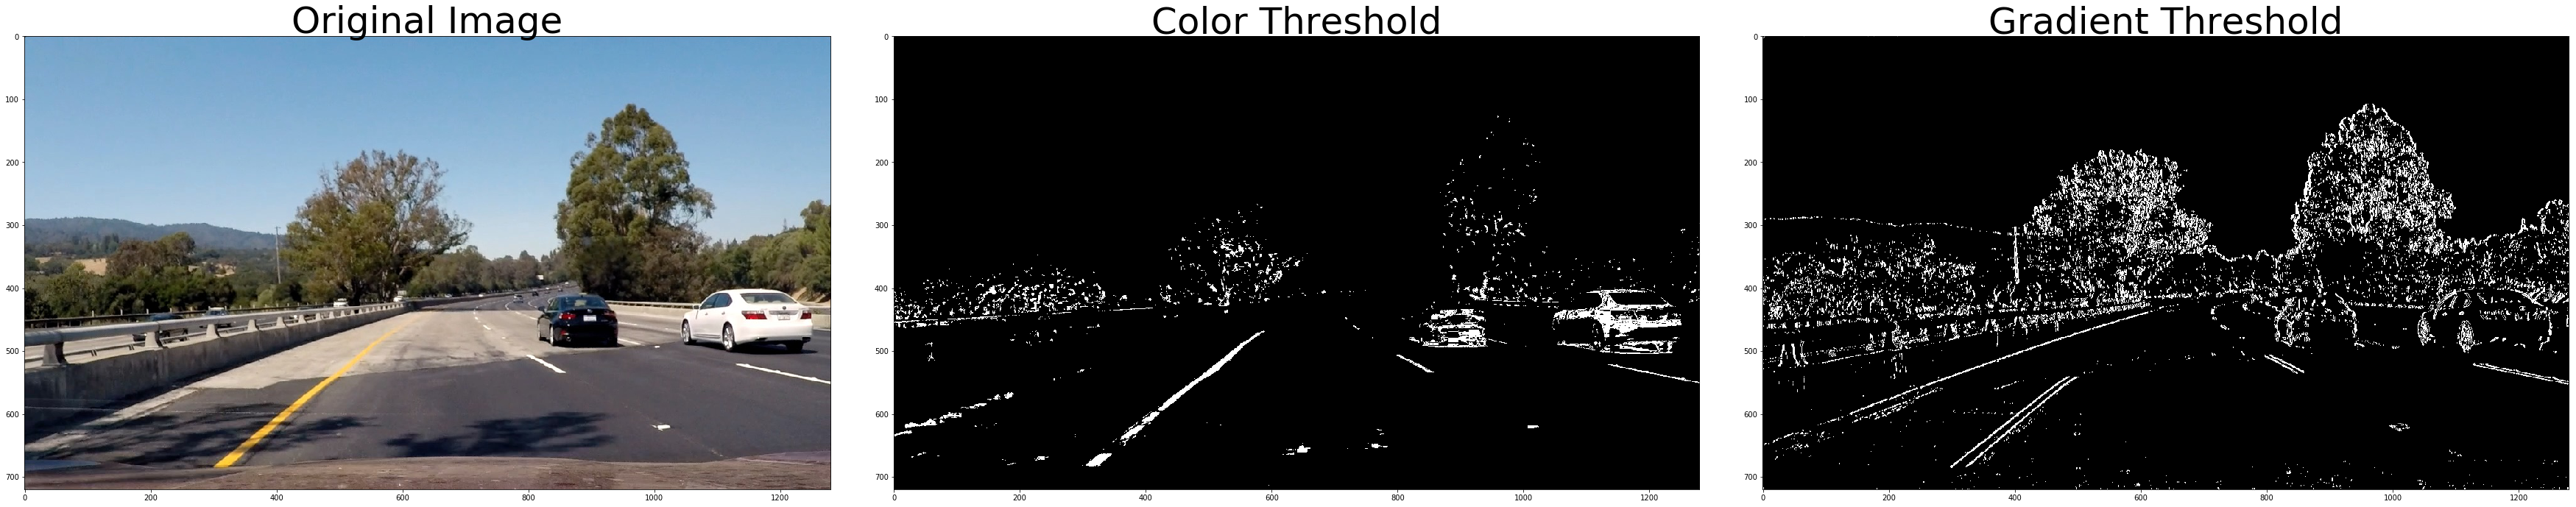

In [190]:
#image = mpimg.imread('test_images/straight_lines1.jpg')
image = mpimg.imread('test_images/test4.jpg')
    
# tune the threshold to try to match the above image!    
color_bin = apply_color_thresh(image, thresh=(170, 255))
print(color_bin.size)

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gradient_bin = apply_gradient_thresh(gray, orient='x', thresh_min=20, thresh_max=100)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 12))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(color_bin, cmap='gray')
ax2.set_title('Color Threshold', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
ax3.imshow(gradient_bin, cmap='gray')
ax3.set_title('Gradient Threshold', fontsize=50)
plt.subplots_adjust(left=0., right=2, top=0.9, bottom=0.)

### Color/Gradient Combined Thresholding Verification (2) 

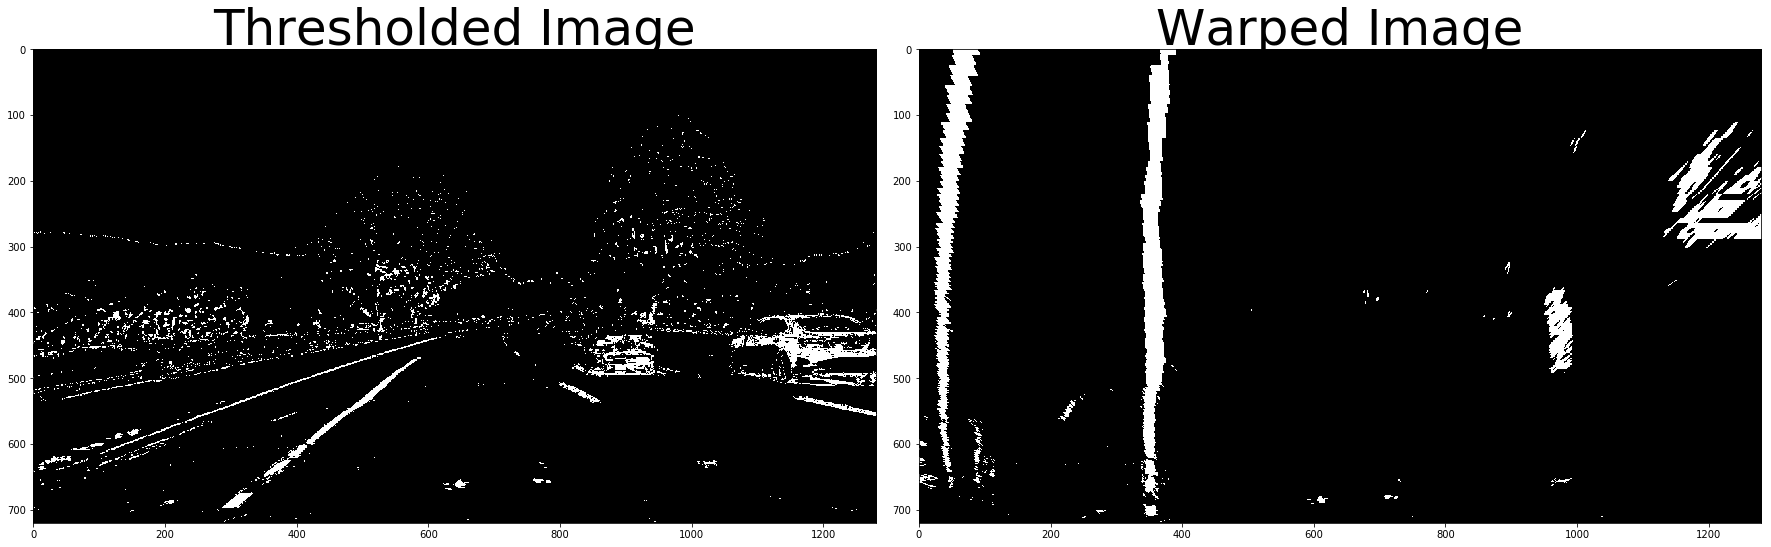

In [191]:
#test_image = mpimg.imread('test_images/straight_lines1.jpg')
test_image = mpimg.imread('test_images/test4.jpg')

# apply color (HLS-S color channel), sobel gradient & directional thresholding
test_thresh_bin = apply_lane_threshold(test_image)
test_color_binary = np.dstack((test_thresh_bin, test_thresh_bin, test_thresh_bin)) * 255

# Perspective Transform
image_shape = test_image.shape
img_size = (image_shape[1], image_shape[0])
img_warped = cv2.warpPerspective(test_thresh_bin, perspective_M, img_size, flags=cv2.INTER_LINEAR)

#plt.imshow(test_thresh_bin, cmap='gray')

# display the original and warped images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_color_binary)
ax1.set_title('Thresholded Image', fontsize=50)
ax2.imshow(img_warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Fourth, Perspective transform from binary image to "birds-eye view"

The easiest way to do this is to investigate a test image where the lane lines are straight, and find four points lying along the lines that, after perspective transform, make the lines look straight and vertical from a bird's eye view perspective. 

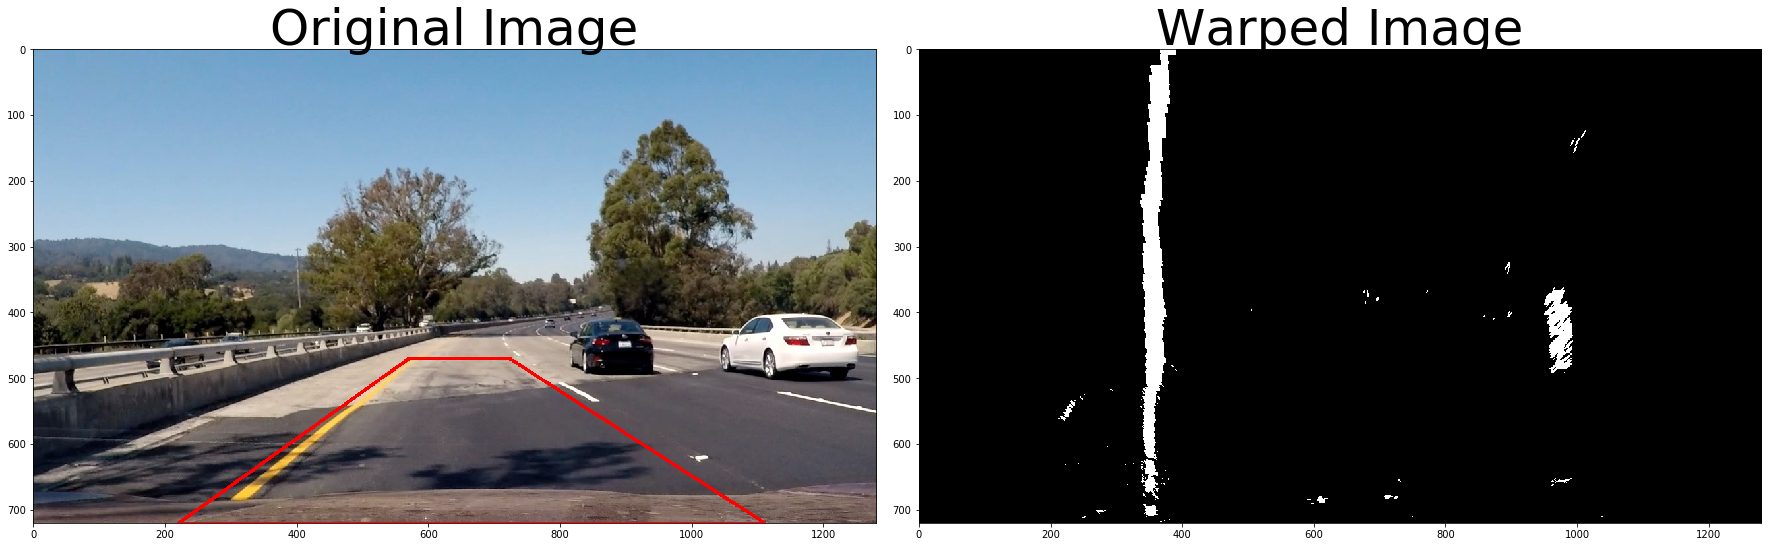

In [193]:
image_shape = test_image.shape

# Source points extracted manually for performing a perspective transform
bottom_left = [220,720]
bottom_right = [1110, 720]
top_left = [570, 470]
top_right = [722, 470]
source = np.float32([bottom_left,bottom_right,top_right,top_left])

# Draw poly lines of the source points
pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
pts = pts.reshape((-1,1,2))
img_copy = test_image.copy()
cv2.polylines(img_copy,[pts],True,(255,0,0), thickness=3)

# Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
bottom_left = [320,720]
bottom_right = [920, 720]
top_left = [320, 1]
top_right = [920, 1]

destination = np.float32([bottom_left,bottom_right,top_right,top_left])

# Get the perspective matrix by passing source and destination points
perspective_M = cv2.getPerspectiveTransform(source, destination)
# Get the inverse perspective matrix 
perspective_M_inv = cv2.getPerspectiveTransform(destination, source)

# Get the bird-view (warped) image by doing the perspective transformation from the test image (thresholded)
img_size = (image_shape[1], image_shape[0])
test_warped = cv2.warpPerspective(test_thresh_bin, perspective_M, img_size, flags=cv2.INTER_LINEAR)

# mask out outside lane lines
mask = np.zeros_like(test_warped)
mask[:,200:1100,] = 1
test_warped = test_warped & mask
    
# Save the warped test image
warped_color = np.dstack((test_warped, test_warped, test_warped)) * 255
cv2.imwrite('examples/straight_lines1_warped.jpg',warped_color)

# display the original and warped images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_copy)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test_warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Run pipeline on all the test images for line detection

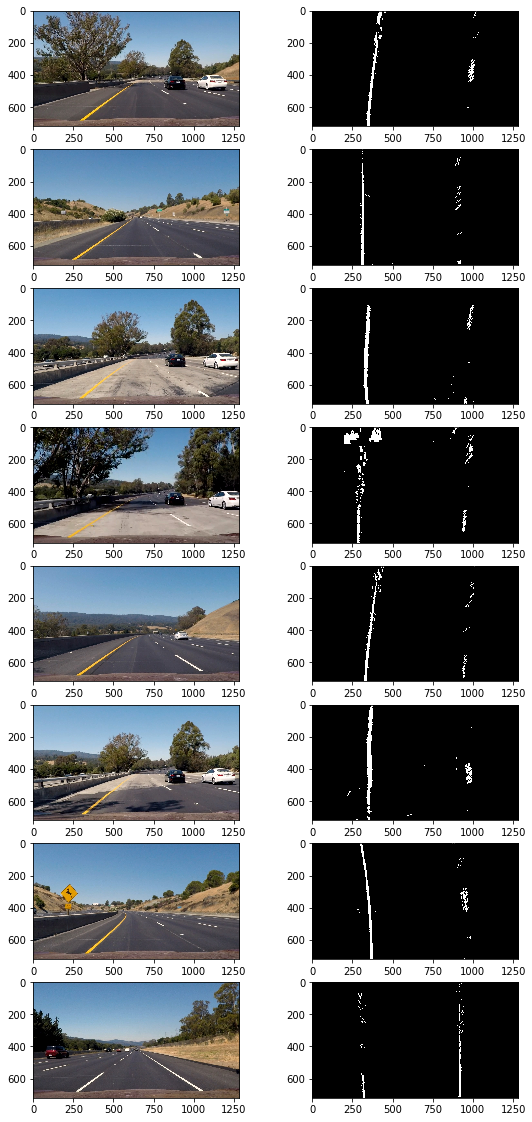

In [192]:
def pipeline(test_image):
    # Undistort
    undist = cv2.undistort(test_image, mtx, dist_coeffs, None, mtx)
    
    # apply color (HLS-S color channel), sobel gradient & directional thresholding
    thresholded_bin = apply_lane_threshold(undist)
    
    # Perspective Transform
    image_shape = test_image.shape
    img_size = (image_shape[1], image_shape[0])
    img_warped = cv2.warpPerspective(thresholded_bin, perspective_M, img_size, flags=cv2.INTER_LINEAR)

    # mask out outside lane lines
    mask = np.zeros_like(img_warped)
    mask[:,200:1100,] = 1
    img_warped = img_warped & mask
    
    color_binary = np.dstack((img_warped, img_warped, img_warped)) * 255

    #return thresholded_bin
    return color_binary


# Pipeline test on all test images provided
# Make a list of example images
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    out_image = pipeline(img)
    axs[i].imshow(img)
    i += 1
    axs[i].imshow(out_image, cmap='gray')
    i += 1

## Fifth, Locate the Lane Lines (Histogram & Slide Window)

### Histogram

After applying calibration, thresholding, and a perspective transform to a road image, you should have a binary image where the lane lines stand out clearly. 
The next step is to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line.

Plotting a histogram of where the binary activations occur across the image is one potential solution for this.

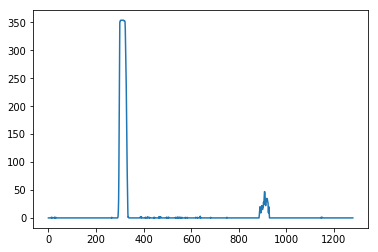

In [8]:
def histogram(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

# Create histogram of image binary activations
hist = histogram(test_warped)

# Visualize the resulting histogram
plt.plot(hist)


### Line class

Line class has been defined to encapsulate the line extraction functionality from the warped image. 

In [57]:
class Line(): 
    def __init__(self):
        self.left_fit = np.array([])
        self.right_fit = np.array([])
               
        self.left_fitx = np.array([])
        self.right_fitx = np.array([])
        self.ploty = np.array([])
        
        self.leftx = np.array([])
        self.rightx = np.array([])
        self.lefty = np.array([])
        self.righty = np.array([])
        
        #radius of curvature of the line and distance from the center
        self.left_curverad = None
        self.right_curverad = None
        self.center_dist = None
        
        # TODO - not being used yet
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]

        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None
        
        
    def slide_window_polyfit(self, warped):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and visualize the result

        warped_clr_img = np.dstack((warped, warped, warped))

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 10
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = warped.shape[0] - (window+1)*window_height
            win_y_high = warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Draw the windows on the visualization image
            cv2.rectangle(warped_clr_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(warped_clr_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
            # Identify the nonzero pixels in x and y within the window #
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        self.leftx = nonzerox[left_lane_inds]
        self.lefty = nonzeroy[left_lane_inds] 
        self.rightx = nonzerox[right_lane_inds]
        self.righty = nonzeroy[right_lane_inds]

        # Fit new polynomials
        self.fit_poly(warped.shape, self.leftx, self.lefty, self.rightx, self.righty)
        
        return warped_clr_img

    
    def search_around_polyfit(self, binary_warped):
        # HYPERPARAMETER
        # width of the margin around the previous polynomial to search
        margin = 100

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        left_lane_inds = ((nonzerox > (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + 
                        self.left_fit[2] - margin)) & (nonzerox < (self.left_fit[0]*(nonzeroy**2) + 
                        self.left_fit[1]*nonzeroy + self.left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + 
                        self.right_fit[2] - margin)) & (nonzerox < (self.right_fit[0]*(nonzeroy**2) + 
                        self.right_fit[1]*nonzeroy + self.right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit new polynomials
        self.fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        warped_clr_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(warped_clr_img)
        # Color in left and right line pixels
        warped_clr_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        warped_clr_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([self.left_fitx-margin, self.ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.left_fitx+margin, 
                                  self.ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([self.right_fitx-margin, self.ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.right_fitx+margin, 
                                  self.ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(warped_clr_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        plt.plot(self.left_fitx, self.ploty, color='yellow')
        plt.plot(self.right_fitx, self.ploty, color='yellow')
        ## End visualization steps ##

        return result


    def fit_poly(self, img_shape, leftx, lefty, rightx, righty):
        ### Fit a second order polynomial to each with np.polyfit() ###
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        
        # Generate x and y values for plotting
        self.ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        ### Calc both polynomials using ploty, left_fit and right_fit ###
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]

    
    def do_polyfit_image(self, warped):
        # Find our lane pixels first
        out_img = self.slide_window_polyfit(warped)

        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[self.lefty, self.leftx] = [255, 0, 0]
        out_img[self.righty, self.rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        plt.plot(self.left_fitx, self.ploty, color='yellow')
        plt.plot(self.right_fitx, self.ploty, color='yellow')

        return out_img

    
    def measure_curvature_center_dist(self, warped):
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(self.ploty)

        self.left_curverad = ((1 + (2*self.left_fit[0]*y_eval*ym_per_pix + self.left_fit[1])**2)**1.5) / np.absolute(2*self.left_fit[0])
        self.right_curverad = ((1 + (2*self.right_fit[0]*y_eval*ym_per_pix + self.right_fit[1])**2)**1.5) / np.absolute(2*self.right_fit[0])

        h = warped.shape[0]
        
        # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
        car_pos = warped.shape[1]/2
        l_fit_x_int = self.left_fit[0]*h**2 + self.left_fit[1]*h + self.left_fit[2]
        r_fit_x_int = self.right_fit[0]*h**2 + self.right_fit[1]*h + self.right_fit[2]
               
        lane_center_pos = (r_fit_x_int + l_fit_x_int) /2
        self.center_dist = (car_pos - lane_center_pos) * xm_per_pix

        return self.left_curverad, self.right_curverad, self.center_dist


### Finding the Lines: Slide Window

We can use the two highest peaks from the histogram as a starting point for determining where the lane lines are, and then use sliding windows moving upward in the image (further along the road) to determine where the lane lines go.

1. Split the histogram for the two lines
2. Set up windows and window hyperparameters
3. Iterate through nwindows to track curvature
4. Fit a polynomial
5. Visualization

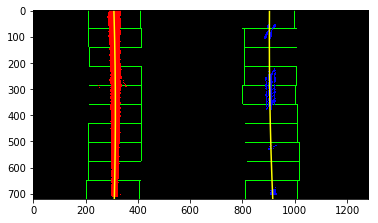

In [54]:
# Test the polynomial fit from the test image and draw the sliding window and fit
#out_img = fit_poly_image(test_warped)

line_obj1 = Line()
test1_out_img = line_obj1.do_polyfit_image(test_warped)

plt.imshow(test1_out_img)
#cv2.imwrite('examples/straight_lines1_polynomial.jpg',test1_out_img)
mpimg.imsave('examples/straight_lines1_polynomial.jpg',test1_out_img)
#plt.savefig('examples/straight_lines1_polynomial.jpg')

## Finding the Lines: Search from Prior

#### Skip the sliding windows step once you've found the lines

Using the full algorithm from before and starting fresh on every frame may seem inefficient, as the lane lines don't necessarily move a lot from frame to frame.
In the next frame of video you don't need to do a blind search again, but instead you can just search in a margin around the previous lane line position, like in the above image. The green shaded area shows where we searched for the lines this time. So, once you know where the lines are in one frame of video, you can do a highly targeted search for them in the next frame. 

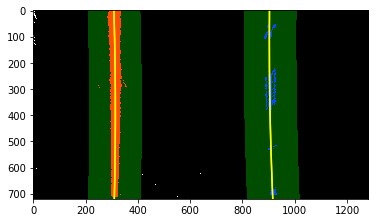

In [55]:

lineobj = Line()
test1_out = lineobj.do_polyfit_image(test_warped)

plt.imshow(test1_out)

# Run image through the pipeline
# Load our image - this should be a new frame since last time!
test2_image = mpimg.imread('test_images/test3.jpg')

# apply color (HLS-S color channel), sobel gradient & directional thresholding
test2_threshed = apply_lane_threshold(test2_image)
#test_color_binary = np.dstack((test_thresh_bin, test_thresh_bin, test_thresh_bin)) * 255

img_size = (test2_threshed.shape[1], test2_threshed.shape[0])
test2_warped = cv2.warpPerspective(test2_threshed, perspective_M, img_size, flags=cv2.INTER_LINEAR)

# Note that in your project, you'll also want to feed in the previous fits
test2_out = lineobj.search_around_polyfit(test_warped)

# View your output
plt.imshow(test2_out)
mpimg.imsave('examples/straight_lines1_search_from_prior.jpg',test2_out)

## Determine the curvature of the lane and vehicle position with respect to center

In [56]:
# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
rad_l, rad_r, d_center = lineobj.measure_curvature_center_dist(test_warped)

print(rad_l, rad_r, d_center)


h,l_fit_x_int,l_fit_y_int= 720 310.122417715 915.891102282
13520.3947437 13942.0170688 0.142678554291


## Draw the detected lanes on the original image

In [58]:
def draw_lane(org_img, bin_img, line, Minv):
    new_img = np.copy(org_img)
    if line.left_fit is None or line.right_fit is None:
        return original_img
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([line.left_fitx, line.ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([line.right_fitx, line.ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(bin_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    h,w = bin_img.shape
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result
    

lane_overlay = draw_lane(test2_image, test_warped, lineobj, perspective_M_inv)
plt.imshow(lane_overlay)

## 